In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline

Part 1. Hopfield Network
In this section we analyse the capacity of a binary Hopfield network (with unit activities 0 and 1.

Exercises 1 and 2.
In this exercise we predict the probability of recalling a bit incorrectly ('error probability') in a network of 100 neurons (exercise 1) and 1000 neurons (exercise 2) as 1, 2, ..., 100, 200, 500, 1000 random patterns are stored in which each bit has 0.5 probability of being 1, and bits are sampled independently from each other and across memorised patterns. Then the error probability is plotted against number of patterns stored on a logarithmic scale.

In [2]:
def analytical_error_prob(N, M):
    """Return the probability of error for memory recollection."""
    mean = (N-1)/8.0
    std = np.sqrt((M-1)*(N-1) / 32.0)
     
    return norm.cdf(0, loc = mean, scale = std)  # return area under dist. from -inf. to 0

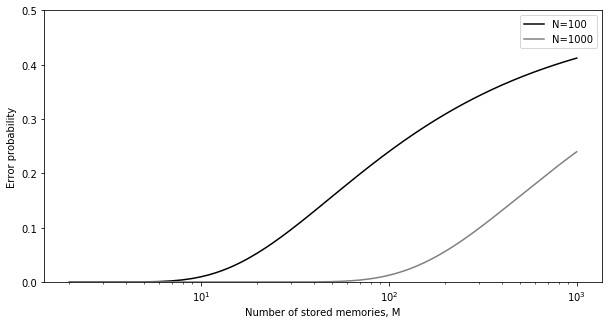

In [6]:
plt.rcParams['figure.figsize'] = [10, 5]

Ms = np.arange(1, 1000, 1)
plt.plot(Ms, analytical_error_prob(100, Ms), color='black')
plt.plot(Ms, analytical_error_prob(1000, Ms), color='grey')
plt.ylim(0,0.5)
plt.xscale('log')
plt.xlabel("Number of stored memories, M")
plt.ylabel("Error probability")
plt.legend(["N={}".format(N) for N in [100,1000]])

Exercise 3. The calculations in exercises 1 and 2 were then verified by running simulations of a Hopfield network with 100 neurons. Different numbers of memories were tried and the error probability was measured.

In [7]:
def get_W(mem_bits):
    """Given a representation of each memory, return an NxN matrix of the weights 
    of the synaptic connections between neurons in a Hopfield network."""
    M,N = mem_bits.shape
    outer_prods = np.zeros([N, N, M])
    for m in range(M):
        outer_prods[:,:,m] =np.outer(mem_bits[m,:]-0.5, mem_bits[m,:]-0.5)
    W = np.sum(outer_prods, 2) * (1-np.identity(N))  # Sum across all memories and then set self-connections to 0
    return W

In [8]:
def simulated_error_prob(N, Ms, p_flip=0):
    """Simulate the error probability during memory recollection, when network is initialised from noisy state."""
    p_errs = []
    for M in Ms:
        p_errs_given_M = []
        for _ in range(int(1000.0/M)):  # Repeat experiment - more repeats for lower M
            mem_bits = np.random.binomial(1, 0.5, (M, N))  # Draw bit patterns for each memory randomly from a Bernoulli distribution with prob. 0.5
            W = get_W(mem_bits)  # Obtain synaptic weights from bit patterns for memories
            noise = np.random.binomial(1, p_flip, (M,N))
            noisy_bits = mem_bits * (1 - noise)  + (1 - mem_bits) * noise  # Add noise to memory states by flipping bits  # WHY is the second term needed?
            fields = np.matmul(W, noisy_bits.T).T  # Field, Hi, for each neuron in each memory. Each row gives a specific memory; each column a specific neuron.
            evolved = fields>0  # Use step activation function to determine which neurons now have bit value 1
            errs = mem_bits != evolved  # There is a bit error if the mem_bit has changed from previous timestep
            n_errs = np.sum(errs, (0,1))
            p_err = float(n_errs) / (M*N)  # Get average error across all memories and neurons
            p_errs_given_M.append(p_err)
        p_errs.append(np.mean(p_errs_given_M))  # Average error prob. across repeats of experiment for each number of patterns, M
    
    return p_errs

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


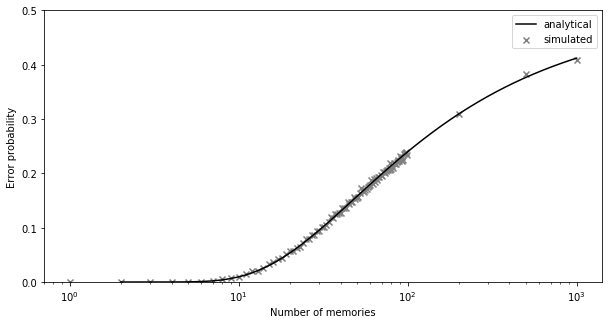

In [13]:
# Plot the error probability against number of stored memories in a simulated network of neurons
Ms = list(range(1, 100)) + [200, 500, 1000]
p_errs = simulated_error_prob(N=100, Ms=Ms, p_flip=0)  # Get error prob. of memory recollection. Start from memory state
plt.scatter(Ms, p_errs, color="grey", marker="x")  # Simulated error probability
plt.plot(np.arange(0,1000, 1), analytical_error_prob(100, np.arange(0,1000, 1)), color='black')  # Analytica error probability
plt.ylim(0,0.5)
plt.xscale('log')
plt.xlabel("Number of memories")
plt.ylabel("Error probability")
plt.legend(["analytical", "simulated"])

In [14]:
Ms = list(range(1, 100)) + [200, 500, 1000]
p_flip = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 1.0]
p_errs = np.zeros([len(p_flip), len(Ms)])
i = 0
for i in range(len(p_flip)):
    p_errs[i,:] = simulated_error_prob(N=100, Ms=Ms, p_flip=p_flip[i])  # Get error prob. of memory recollection. Start from noisy state.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


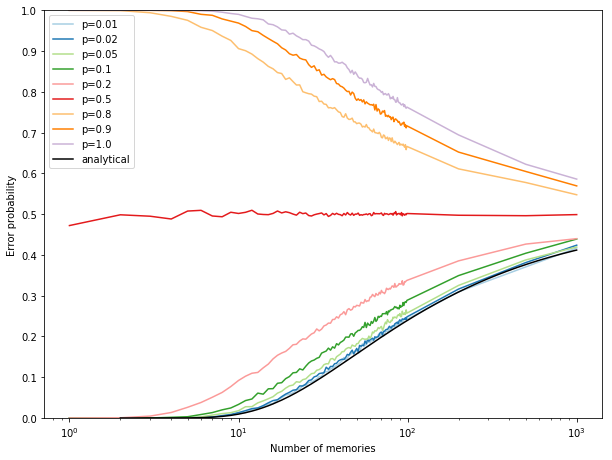

In [37]:
# Plot the error probability for simulated network for varying degrees of noise
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Paired.colors)
plt.yticks(np.arange(-0.0, 1.1, 0.1))
for i in range(len(p_flip)):
    plt.plot(Ms, p_errs[i,:])  # Simulated error probability
    plt.ylim(0,1.0)
    plt.xscale('log')
    plt.xlabel("Number of memories")
    plt.ylabel("Error probability")
plt.plot(np.arange(0,1000, 1), analytical_error_prob(100, np.arange(0,1000, 1)), color='black')  # Analytical error probability
plt.legend(["p={}".format(flip) for flip in p_flip] + ["analytical"])

Part 2. Exploration of a physiological model of a spiking neuron

In [38]:
from numpy import exp

def alpha_m(V):
    am = (2.5-0.1*(V+65)) / (exp(2.5-0.1*(V+65)) -1)
    return am

def beta_m(V):
    bm = 4*exp(-(V+65)/18)
    return bm

def alpha_h(V):
    ah = 0.07*exp(-(V+65)/20)
    return ah

def beta_h(V):
    bh = 1./(exp(3.0-0.1*(V+65))+1)
    return bh

def alpha_n(V):
    an = (0.1-0.01*(V+65)) / (exp(1-0.1*(V+65)) -1)
    return an

def beta_n(V):
    bn = 0.125*exp(-(V+65)/80)
    return bn

# NOTE that the above functions operate in mV therefore other parameter scales I used below should be adjusted accordingly?
# THINK of modifying the scales of the parameters below
g_Na = 120  # WHAT are the units to be used?! Should I use 120 or 1.20 like the textbook says?
g_K = 36
g_L = 0.3

e_Na = 50
e_K = -77
e_L = -54.4

dt = 0.001

In [39]:
# This function uses forward Euler integration to integrate v, m, h, and n over the duration of a current pulse
def integrate_v(v0, m0, h0, n0, I_ext):
    v = v0
    m = m0
    h = h0
    n = n0
    vs = [v0]
    for I in I_ext:
        vdot = -g_Na * m**3 * h * (v - e_Na) - g_K * n**4 * (v - e_K) - g_L * (v - e_L) + I
        mdot = alpha_m(v) * (1-m) - beta_m(v) * m
        hdot = alpha_h(v) * (1-h) - beta_h(v) * h
        ndot = alpha_n(v) * (1-n) - beta_n(v) * n
        v += vdot * dt
        m += mdot * dt
        h += hdot * dt
        n += ndot * dt
        vs.append(v)
    return vs

In [31]:
# Get membrane potential, v, over 200ms pulse for 9 values of I_ext in range 0.1 mA/nF to 5 mA/nF
pulse_dur = 200
dur = 400
pulse_time = np.arange(100, 100 + pulse_dur+dt, dt)
no_signal_time = np.arange(0,100,dt)
Is = np.linspace(0.1,5,9)
all_vs = []
for I in Is:
    I_ext = [0 for _ in range(len(no_signal_time))]
    I_ext += [I for _ in range(len(pulse_time)-1)]
    I_ext += [0 for _ in range(len(no_signal_time))]
    all_vs.append(integrate_v(v0=-65, m0=0.08, h0=0.6, n0=0.33, I_ext=I_ext))

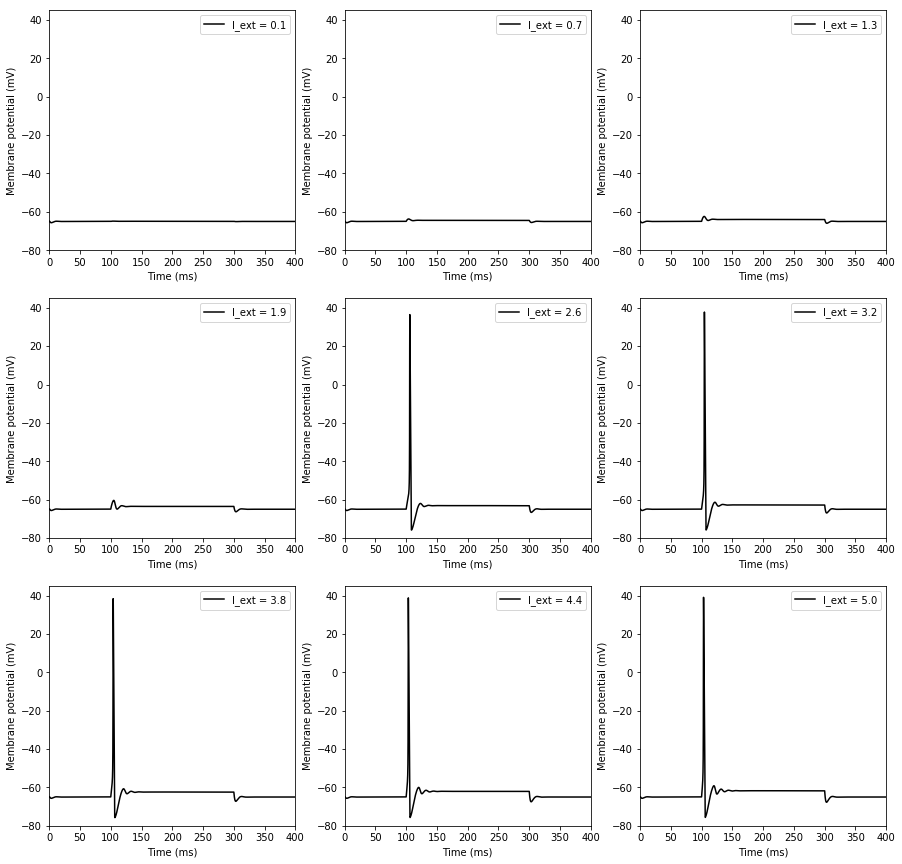

In [32]:
# Plot membrane potential, v, over 200ms pulse for 9 values of I_ext
no_signal_after = 300 + no_signal_time
time = list(no_signal_time) + list(pulse_time) + list(no_signal_after)
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
row = 0
for i in range(len(all_vs)):
    axs[row, i%3].set_xlim(0,400)
    axs[row, i%3].set_ylim(-80,45)
    axs[row, i%3].set_xlabel('Time (ms)')
    axs[row, i%3].set_ylabel('Membrane potential (mV)')
    axs[row, i%3].plot(time, all_vs[i], color="black", label="I_ext = {0:.1f}".format(Is[i]))
    axs[row, i%3].legend()
    row = row + 1 if i%3 == 2 else row

In [36]:
# Get membrane potential, v, over 200ms pulse for 3 values of I_ext i.e. [2.1, 2.2, 2.3]
pulse_dur = 200
dur = 400
pulse_time = np.arange(100, 100 + pulse_dur+dt, dt)
no_signal_time = np.arange(0,100,dt)
Is = [2.1, 2.2, 2.3]
all_vs = []
for I in Is:
    I_ext = [0 for _ in range(len(no_signal_time))]
    I_ext += [I for _ in range(len(pulse_time)-1)]
    I_ext += [0 for _ in range(len(no_signal_time))]
    all_vs.append(integrate_v(v0=-65, m0=0.08, h0=0.6, n0=0.33, I_ext=I_ext))

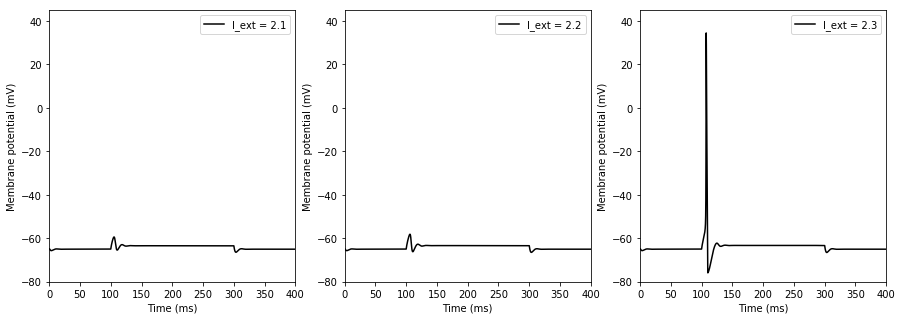

In [38]:
# Plot membrane potential, v, over 200ms pulse for 3 values of I_ext [2.1, 2.2, 2.3]
no_signal_after = 300 + no_signal_time
time = list(no_signal_time) + list(pulse_time) + list(no_signal_after)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(all_vs)):
    axs[i].set_xlim(0,400)
    axs[i].set_ylim(-80,45)
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Membrane potential (mV)')
    axs[i].plot(time, all_vs[i], color="black", label="I_ext = {0:.1f}".format(Is[i]))
    axs[i].legend()

In [5]:
# Get membrane potential, v, over 200ms pulse for 3 values of I_ext in range 6 mA/nF to 20 mA/nF
pulse_dur = 200
dur = 400
pulse_time = np.arange(100, 100 + pulse_dur+dt, dt)
no_signal_time = np.arange(0,100,dt)
Is = np.linspace(6,20,3)
all_vs = []
for I in Is:
    I_ext = [0 for _ in range(len(no_signal_time))]
    I_ext += [I for _ in range(len(pulse_time)-1)]
    I_ext += [0 for _ in range(len(no_signal_time))]
    all_vs.append(integrate_v(v0=-65, m0=0.08, h0=0.6, n0=0.33, I_ext=I_ext))

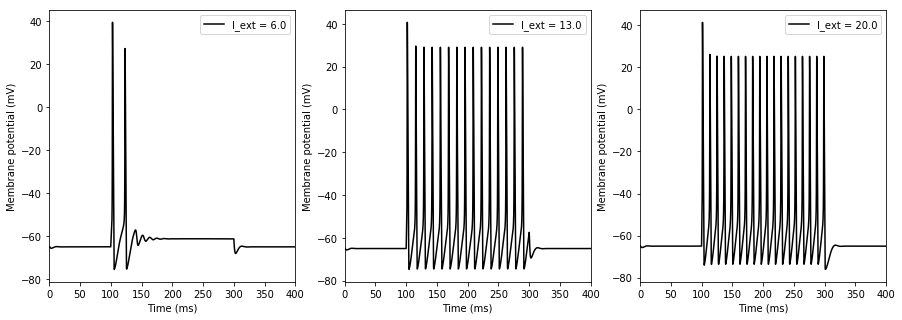

In [7]:
# Plot membrane potential, v, over 200ms pulse for 3 values of I_ext in range 6 mA/nF to 20 mA/nF
no_signal_after = 300 + no_signal_time
time = list(no_signal_time) + list(pulse_time) + list(no_signal_after)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
row = 0
for i in range(len(all_vs)):
    axs[i%3].set_xlim(0,400)
#     axs[i%3].set_ylim(-80,45)
    axs[i%3].set_xlabel('Time (ms)')
    axs[i%3].set_ylabel('Membrane potential (mV)')
    axs[i%3].plot(time, all_vs[i], color="black", label="I_ext = {0:.1f}".format(Is[i]))
    axs[i%3].legend()

In [22]:
# Get membrane potential, v, over 200ms pulse for 9 values of I_ext in range 6 mA/nF to 30 mA/nF
pulse_dur = 200
dur = 400
pulse_time = np.arange(100, 100 + pulse_dur+dt, dt)
no_signal_time = np.arange(0,100,dt)
Is = np.linspace(6,30,9)
all_vs = []
for I in Is:
    I_ext = [0 for _ in range(len(no_signal_time))]
    I_ext += [I for _ in range(len(pulse_time)-1)]
    I_ext += [0 for _ in range(len(no_signal_time))]
    all_vs.append(integrate_v(v0=-65, m0=0.08, h0=0.6, n0=0.33, I_ext=I_ext))

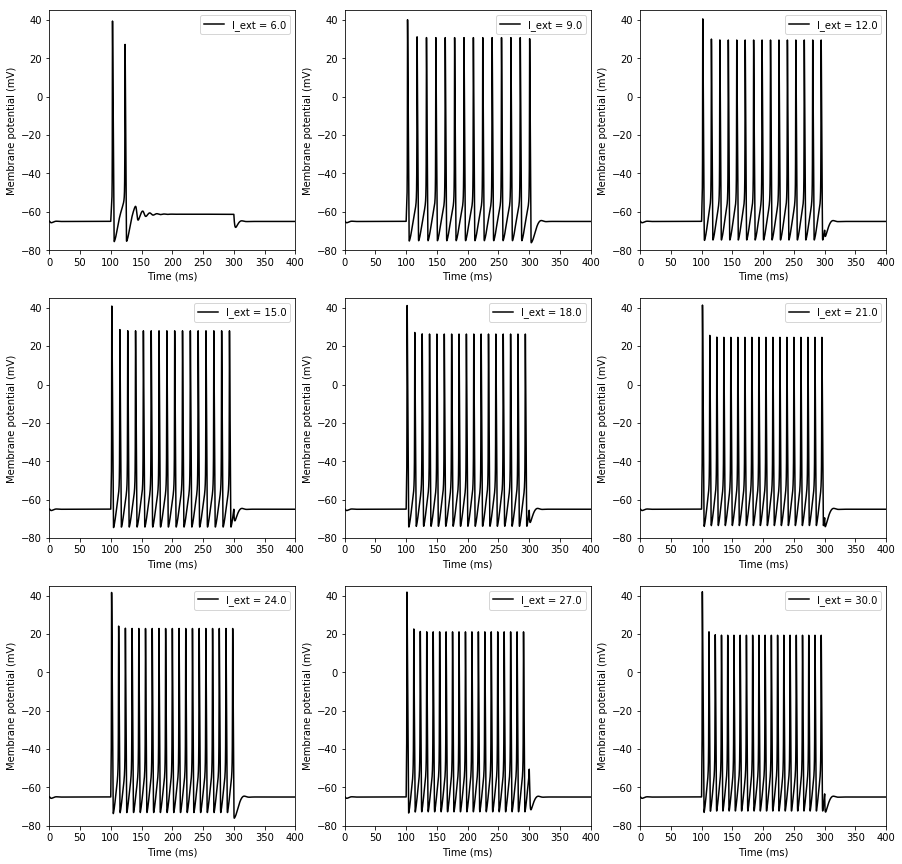

In [24]:
# Plot membrane potential, v, over 200ms pulse for 9 values of I_ext in range 6 mA/nF to 30 mA/nF
no_signal_after = 300 + no_signal_time
time = list(no_signal_time) + list(pulse_time) + list(no_signal_after)
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
row = 0
for i in range(len(all_vs)):
    axs[row, i%3].set_xlim(0,400)
    axs[row, i%3].set_ylim(-80,45)
    axs[row, i%3].set_xlabel('Time (ms)')
    axs[row, i%3].set_ylabel('Membrane potential (mV)')
    axs[row, i%3].plot(time, all_vs[i], color="black", label="I_ext = {0:.1f}".format(Is[i]))
    axs[row, i%3].legend()
    row = row + 1 if i%3 == 2 else row

In [50]:
# Get membrane potential, v, over 200ms pulse for 8 values of I_ext in range 1 mA/nF to 8 mA/nF
pulse_dur = 200
dur = 400
pulse_time = np.arange(100, 100 + pulse_dur+dt, dt)
no_signal_time = np.arange(0,100,dt)
Is = np.linspace(6.24,6.36,4)
all_vs = []
for I in Is:
    I_ext = [0 for _ in range(len(no_signal_time))]
    I_ext += [I for _ in range(len(pulse_time)-1)]
    I_ext += [0 for _ in range(len(no_signal_time))]
    all_vs.append(integrate_v(v0=-65, m0=0.08, h0=0.6, n0=0.33, I_ext=I_ext))

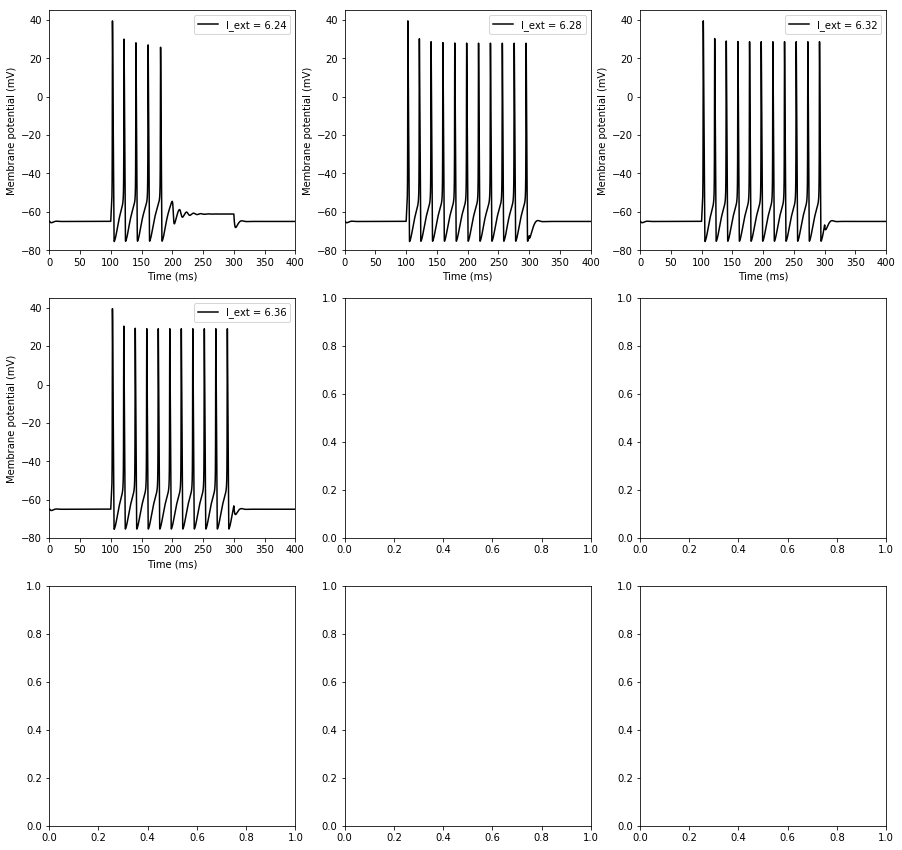

In [52]:
# Plot membrane potential, v, over 200ms pulse for 8 values of I_ext in range 1 mA/nF to 8 mA/nF
no_signal_after = 300 + no_signal_time
time = list(no_signal_time) + list(pulse_time) + list(no_signal_after)
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
row = 0
for i in range(len(all_vs)):
    axs[row, i%3].set_xlim(0,400)
    axs[row, i%3].set_ylim(-80,45)
    axs[row, i%3].set_xlabel('Time (ms)')
    axs[row, i%3].set_ylabel('Membrane potential (mV)')
    axs[row, i%3].plot(time, all_vs[i], color="black", label="I_ext = {0:.2f}".format(Is[i]))
    axs[row, i%3].legend()
    row = row + 1 if i%3 == 2 else row

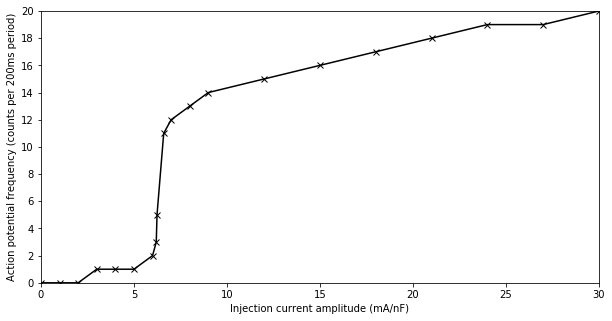

In [85]:
plt.xlabel('Injection current amplitude (mA/nF)')
plt.ylabel('Action potential frequency (counts in 200 ms)')
plt.xlim(0,30)
plt.ylim(0,20)
plt.yticks(np.arange(0, 22, 2))
plt.plot([0,1,2,3,4,5,6,6.2,6.24,6.6,7,8,9,12,15,18,21,24,27,30], np.array([0,0,0,1,1,1,2,3,5,11,12,13,14,15,16,17,18,19,19,20]), color="black", marker='x')
plt.rcParams['figure.figsize'] = [10, 5]
# plt.annotate('(6)', [6.5, 9])
# plt.annotate('(6.24, 20)', [6.24, 20])
# 6,4 11
# 6.6 12
# 6.8 12
# 7 12

In [43]:
def periodic_square_pulse(amp, p, T, dur, dt=0.001):
    """
    Generate periodic square pulse with a pulse-width, p, and a period, T.
    The input starts at amplitude 0 and rises to magnitude I during a pulse.
    The waveform runs for the duration, dur, specified. 
    dt gives the discrete time increment
    """
    on = False
    wave = []
    
    t = np.arange(0, T+2*dt, dt)
    i = 0
    for time in np.arange(0,dur,dt):
        if(t[i] >= T):
            i = 0
        wave.append(amp if t[i] >= T-p else 0)
        i += 1
    return wave

In [57]:
# Simulate response of membrane potential to periodic square pulse input with varying period T and I=2.3mA/nF
pulse_dur = 5
dur = 400
# Ts = np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
Ts = np.arange(10,21,1)
Is = []
all_vs = []
for T in Ts:
    print(T)
    I_ext = periodic_square_pulse(2.3, pulse_dur, T, dur, dt)
    Is.append(I_ext)
    all_vs.append(integrate_v(v0=-65, m0=0.08, h0=0.6, n0=0.33, I_ext=I_ext))

10
11
12
13
14
15
16
17
18
19
20


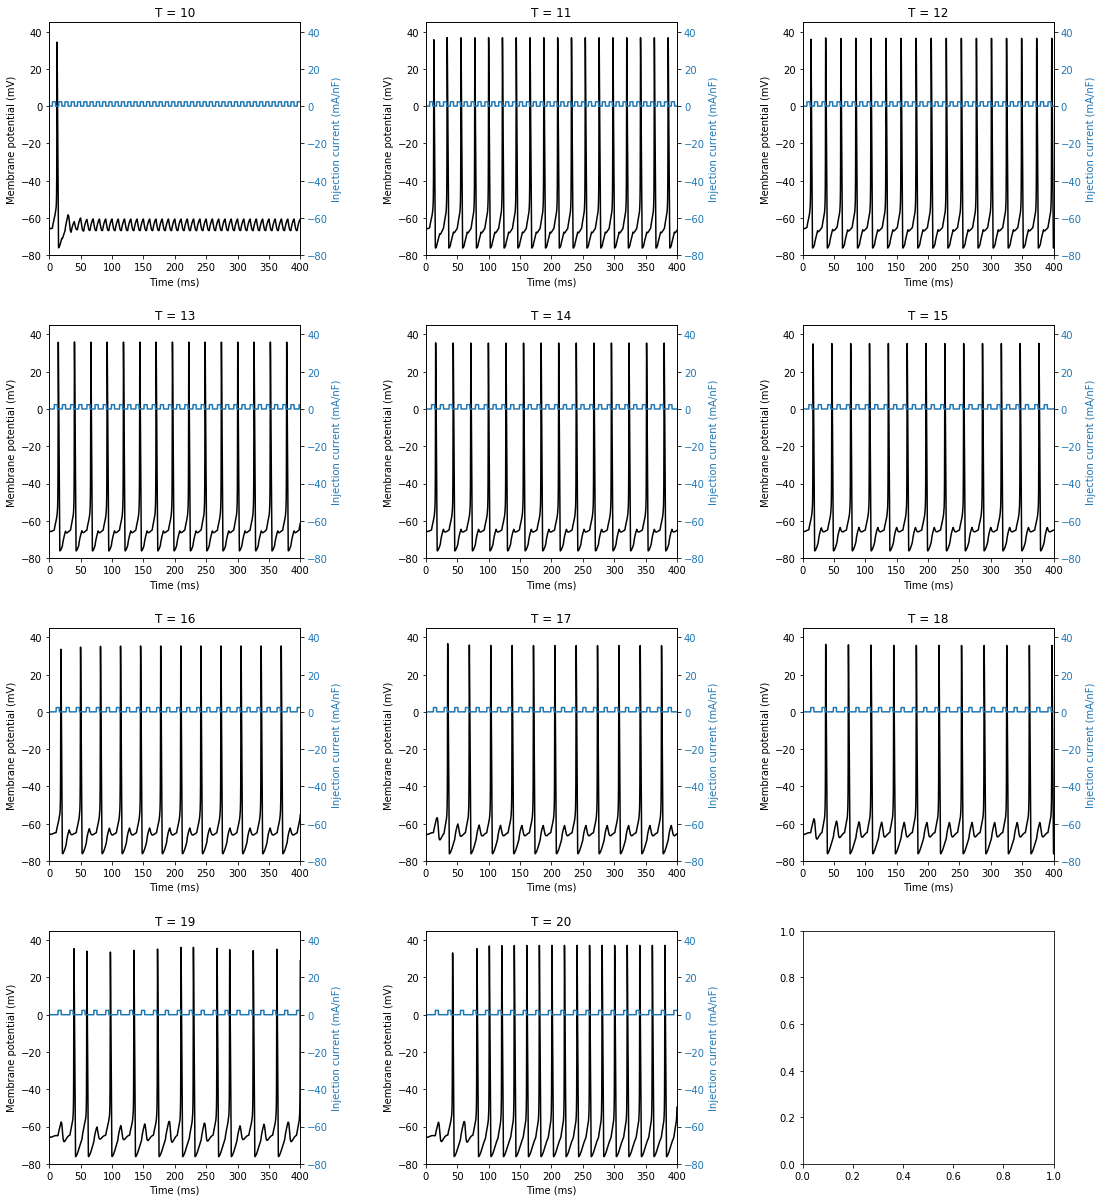

In [56]:
# Plot response of membrane potential to periodic square pulse input with varying period T
time = np.arange(0,dur+dt,dt)
fig, axs = plt.subplots(4, 3, figsize=(18, 21))
plt.subplots_adjust(wspace=0.5, hspace = 0.3)  # adjust spacing between plots
row = 0
for i in range(len(all_vs)):
    axs[row, i%3].set_xlim(0,dur)
    axs[row, i%3].set_ylim(-80,45)
    axs[row, i%3].set_xlabel('Time (ms)')
    axs[row, i%3].set_ylabel('Membrane potential (mV)')
    axs[row, i%3].plot(time, all_vs[i], color="black", label="T = {0}".format(Ts[i]))
#     axs[row, i%3].legend(loc='upper right')
    axs[row, i%3].set_title('T = {0}'.format(Ts[i]))
    axs_2_color = 'tab:blue'
    axs_2 = axs[row, i%3].twinx()
    axs_2.set_ylabel('Injection current (mA/nF)', color=axs_2_color)
    axs_2.plot(time, Is[i]+[Is[i][-1]], color=axs_2_color)
    axs_2.set_ylim(-80,45)
    axs_2.tick_params(axis='y', labelcolor=axs_2_color)
    row = row + 1 if i%3 == 2 else row

In [78]:
# Simulate response of membrane potential to large periodic square pulse input with varying period T and I=2.3mA/nF
pulse_dur = 5
dur = 400
Ts = np.array([12])
Is = []
all_vs = []
for T in Ts:
    print(T)
    I_ext = periodic_square_pulse(101, pulse_dur, T, dur, dt)
    Is.append(I_ext)
    all_vs.append(integrate_v(v0=-65, m0=0.08, h0=0.6, n0=0.33, I_ext=I_ext))

12


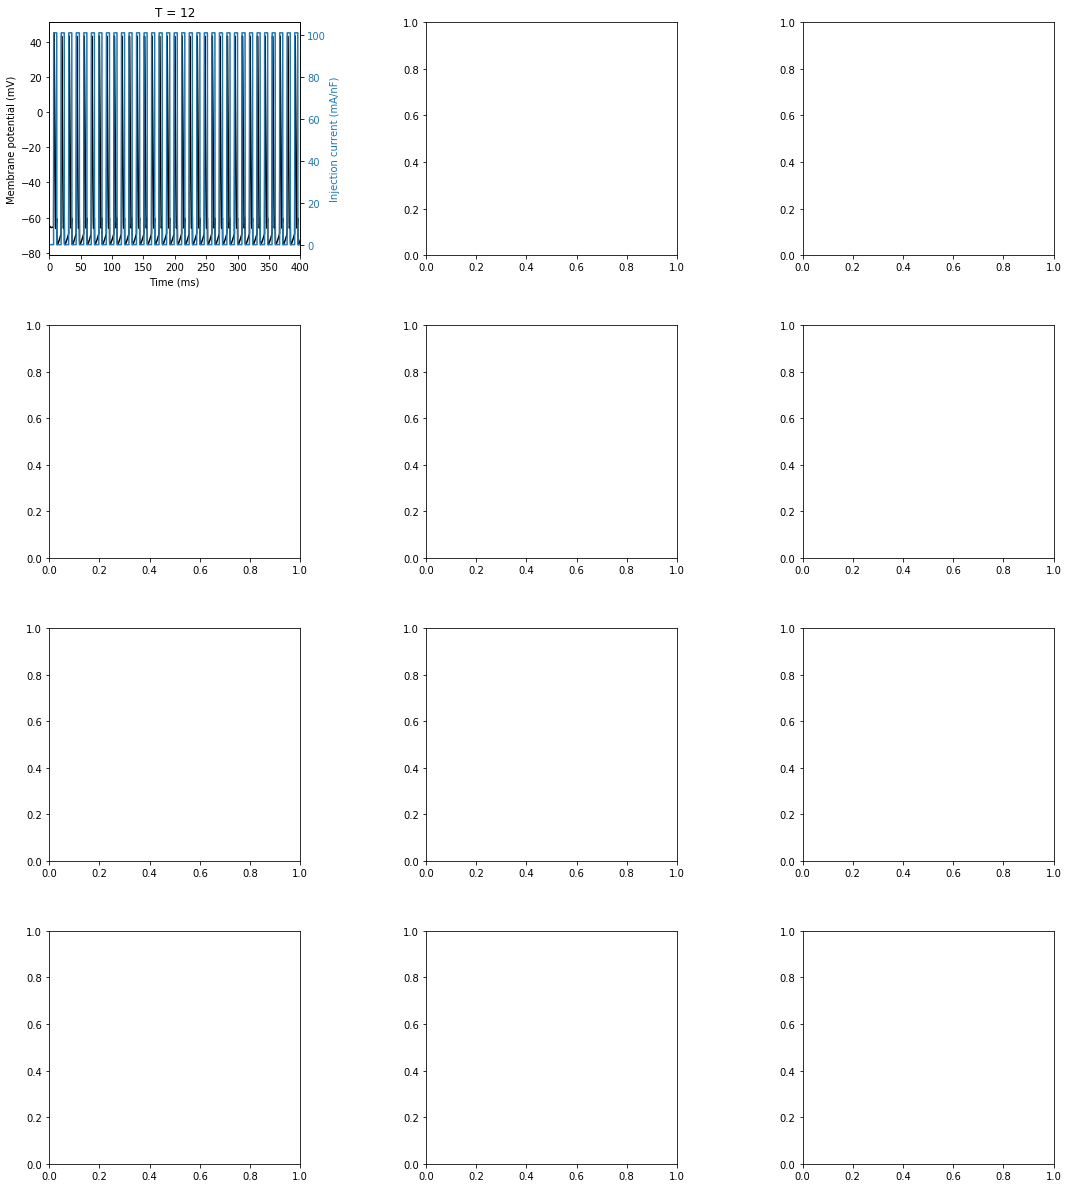

In [81]:
# Plot response of membrane potential to negative periodic square pulse input with varying period T
time = np.arange(0,dur+dt,dt)
fig, axs = plt.subplots(4, 3, figsize=(18, 21))
plt.subplots_adjust(wspace=0.5, hspace = 0.3)  # adjust spacing between plots
row = 0
for i in range(len(all_vs)):
    axs[row, i%3].set_xlim(0,dur)
#     axs[row, i%3].set_ylim(-80,45)
    axs[row, i%3].set_xlabel('Time (ms)')
    axs[row, i%3].set_ylabel('Membrane potential (mV)')
    axs[row, i%3].plot(time, all_vs[i], color="black", label="T = {0}".format(Ts[i]))
#     axs[row, i%3].legend(loc='upper right')
    axs[row, i%3].set_title('T = {0}'.format(Ts[i]))
    axs_2_color = 'tab:blue'
    axs_2 = axs[row, i%3].twinx()
    axs_2.set_ylabel('Injection current (mA/nF)', color=axs_2_color)
    axs_2.plot(time, Is[i]+[Is[i][-1]], color=axs_2_color)
#     axs_2.set_ylim(-80,45)
    axs_2.tick_params(axis='y', labelcolor=axs_2_color)
    row = row + 1 if i%3 == 2 else row

In [13]:
# Simulate response of membrane potential to negative periodic square pulse input with varying period T and I=2.3mA/nF
pulse_dur = 5
dur = 80
T = 12

I_ext = periodic_square_pulse(-5, pulse_dur, T, dur, dt)
Is = I_ext
vs = integrate_v(v0=-65, m0=0.08, h0=0.6, n0=0.33, I_ext=I_ext)

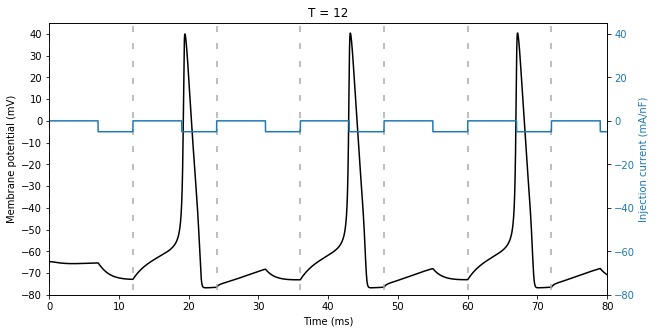

In [30]:
# Plot response of membrane potential to negative periodic square pulse input with varying period T
time = np.arange(0,dur+dt,dt)
# fig, axs = plt.subplots(4, 3, figsize=(18, 21))
# plt.subplots_adjust(wspace=0.5, hspace = 0.3)  # adjust spacing between plots
# row = 0
plt.rcParams['figure.figsize'] = [10, 5]

plt.xlim(0,dur)
plt.ylim(-80,45)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.yticks(np.arange(-80, 50, 10))
plt.plot(time, vs, color="black", label="T = {0}".format(T))

plt.title('T = {0}'.format(T))
axs_2_color = 'tab:blue'
axs_2 = plt.twinx()
axs_2.set_ylabel('Injection current (mA/nF)', color=axs_2_color)
axs_2.plot(time, Is+[Is[-1]], color=axs_2_color)
axs_2.set_ylim(-80,45)
axs_2.tick_params(axis='y', labelcolor=axs_2_color)

dashes = np.linspace(-100,50,20)
for i in range(7):
    plt.scatter([T*i]*len(dashes),dashes, color='#aaaaaa', marker='|')

In [ ]:
# Plot membrane potential, v, over 200ms pulse for 10 values of I_ext
no_signal_after = 300 + no_signal_time
time = list(no_signal_time) + list(pulse_time) + list(no_signal_after)
plt.rcParams['figure.figsize'] = [10, 5]
for i in range(len(all_vs)):
    plt.plot(time, all_vs[i])
plt.xlim(0,400)
# plt.ylim(bottom=0)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.legend(["I_ext = {0:.1f}".format(I) for I in Is])